In [ ]:
import pandas as pd
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-airline-sentiment


In [208]:
df = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
# get columns
data = df[['text', 'airline_sentiment']].copy()
data.columns = ['text', 'label']  # rename
# check
print(data['label'].value_counts())

label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [209]:
print(data.head())

                                                text     label
0                @VirginAmerica What @dhepburn said.   neutral
1  @VirginAmerica plus you've added commercials t...  positive
2  @VirginAmerica I didn't today... Must mean I n...   neutral
3  @VirginAmerica it's really aggressive to blast...  negative
4  @VirginAmerica and it's a really big bad thing...  negative


In [210]:
import re

# clean the texts
def clean_tweet(text):
    text = re.sub(r'@\w+', '', text)          # remove @
    text = re.sub(r'http\S+', '', text)       # remove URL
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.lower().strip()               # lower texts
    words = text.split()
    stops = set(stopwords.words('english'))   # remove stopwords
    words = [word for word in words if word not in stops]
    return ' '.join(words)

#
data['cleaned_text'] = data['text'].apply(clean_tweet)
data = data[data['cleaned_text'].str.len() > 1]

# Encoded Label（negative:0, neutral:1, positive:2）
label_map = {'negative':0, 'neutral':1, 'positive':2}
data['label_encoded'] = data['label'].map(label_map)

<ipython-input-210-dfa7ef422a8b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_encoded'] = data['label'].map(label_map)


In [211]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

maxlen = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    data['label_encoded'],
    test_size=0.2,
    stratify=data['label_encoded'],
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42
)

In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.regularizers import l2

# Increase the convolution kernel size (kernel_size=5)
model_v2 = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # change the kernel_size
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.7),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [214]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [215]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_12         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [216]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

class_weights = {
    0: len(data) / (3 * np.bincount(data['label_encoded'])[0]),  # negative
    1: len(data) / (3 * np.bincount(data['label_encoded'])[1]),  # neutral
    2: len(data) / (3 * np.bincount(data['label_encoded'])[2])   # positive
}

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,  # 类别权重
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5378 - loss: 1.0549 - val_accuracy: 0.7017 - val_loss: 0.7250
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7644 - loss: 0.6424 - val_accuracy: 0.7530 - val_loss: 0.6362
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8608 - loss: 0.4157 - val_accuracy: 0.7385 - val_loss: 0.6908
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9153 - loss: 0.2573 - val_accuracy: 0.7530 - val_loss: 0.7307
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9521 - loss: 0.1679 - val_accuracy: 0.7479 - val_loss: 0.8584


In [217]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

92/92 - 1s - 7ms/step - accuracy: 0.7547 - loss: 0.6216
test accuracy: 0.7547, loss: 0.6216


In [218]:
# generate predicted results
y_pred = np.argmax(model.predict(X_test), axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [219]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.79      0.84      1834
     neutral       0.57      0.62      0.59       617
    positive       0.59      0.81      0.68       472

    accuracy                           0.75      2923
   macro avg       0.69      0.74      0.70      2923
weighted avg       0.78      0.75      0.76      2923



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report (version 2)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.80      0.84      1834
     neutral       0.55      0.63      0.59       617
    positive       0.64      0.79      0.71       472

    accuracy                           0.76      2923
   macro avg       0.69      0.74      0.71      2923
weighted avg       0.78      0.76      0.77      2923



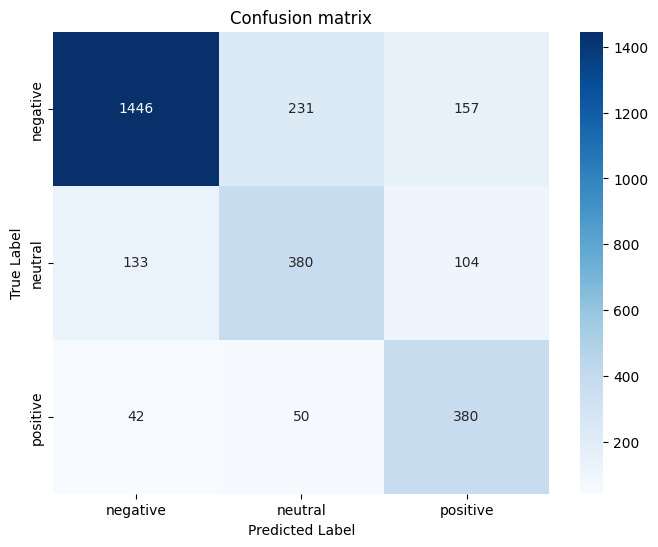

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualization of confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_map.keys(),
           yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

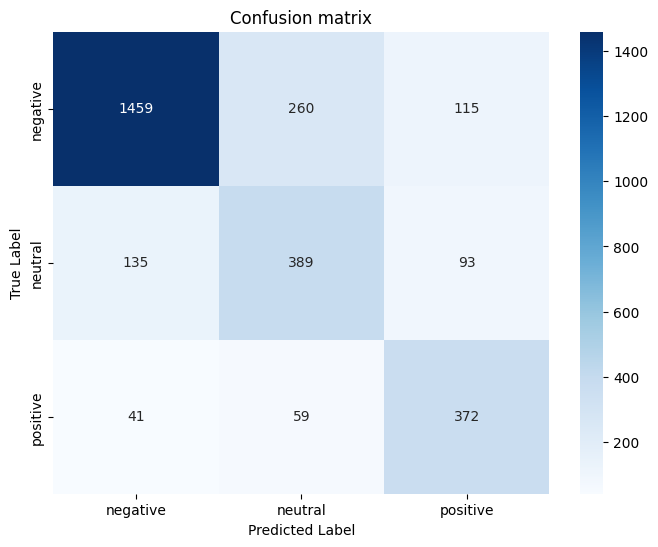

In [ ]:
# increased the kernel_size to improve the prediction of neutral label, and accuracy is higher so maybe this parameter is better ^v^
import matplotlib.pyplot as plt
import seaborn as sns

# visualization of confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_map.keys(),
           yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

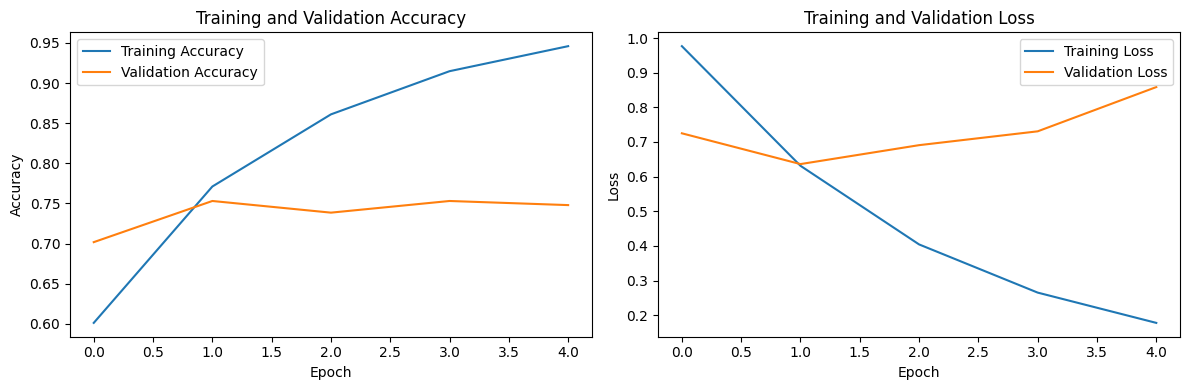

In [221]:
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('twitter_sentiment_cnn.h5')